In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [8]:
EPS = 1e-4
BASELINE_F1 = 0.7758620689655172

In [9]:
def compare_models(results_list, compare_lr=False, title="F1 Score by Layer"):
    results_dir = os.path.join(os.getcwd(), "results")
    for result in results_list:
        result_dir = os.path.join(results_dir, result)
        ccs_f1s = np.load(os.path.join(result_dir, "ccs_f1s.npy"))
        plt.scatter(range(len(ccs_f1s)), ccs_f1s, label=result)
        #plt.plot(range(len(ccs_f1s)), ccs_f1s)

    if compare_lr:
        result_dir = os.path.join(os.getcwd(), "results/gpt2-xl_all-prompts")
        lr_f1s = np.load(os.path.join(result_dir, "lr_f1s.npy"))
        plt.plot(range(len(lr_f1s)), lr_f1s, label="gpt2-xl_all-prompts LR baseline", color="pink")

    ax = plt.gca()
    ax.legend(bbox_to_anchor=(1.05, 1))

    plt.axhline(y=BASELINE_F1, color="pink", linestyle="-")
    # Set range
    plt.ylim(0, 1)
    plt.title(title)
    plt.xlabel("Layer")
    plt.ylabel("F1 Score")

    plt.show()

In [10]:
def plot_lr_ccs_diffs(results_list, title="Lr vs. CCS F1 Difference by Layer"):
    results_dir = os.path.join(os.getcwd(), "results")
    for result in results_list:
        result_dir = os.path.join(results_dir, result)
        lr_f1s = np.load(os.path.join(result_dir, "lr_f1s.npy"))
        ccs_f1s = np.load(os.path.join(result_dir, "ccs_f1s.npy"))
        diff_f1s = lr_f1s - ccs_f1s
        plt.scatter(range(len(diff_f1s)), diff_f1s, label=result)

    ax = plt.gca()
    ax.legend(bbox_to_anchor=(1.05, 1))

    plt.axhline(y=BASELINE_F1, color="pink", linestyle="-")
    # Set range
    plt.ylim(0, 1)
    plt.title(title)
    plt.xlabel("Layer")
    plt.ylabel("LR F1 - CCS F1")

    plt.show()

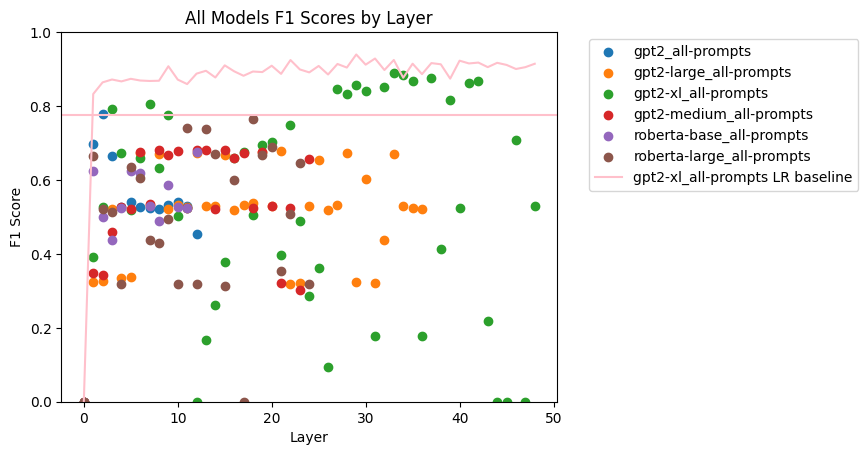

In [11]:
results_list = ["gpt2_all-prompts",
                "gpt2-large_all-prompts",
                "gpt2-xl_all-prompts",
                "gpt2-medium_all-prompts",
                "roberta-base_all-prompts",
                "roberta-large_all-prompts"]
compare_models(results_list, compare_lr=True, title="All Models F1 Scores by Layer")
#plot_lr_ccs_diffs(["gpt2-xl_all-prompts"])